# Gumbel-Softmax - New feature
This notebook showcases a new feature introduced in version 0.6, Gumbel-Softmax activations!

**Structure of the notebook:**

1. A quick recap on categorical feature synthesis
2. Softmax and the Gumbel-Softmax activation
3. Synthesized categorical features comparison
    * Raw sample format comparison
    * Synthesized samples comparison (categoricals)

## A quick recap on categorical feature synthesis
Before synthesizing we typically preprocess our features. In the case of categorical features, one-hot encodings are frequently used in order to transform discrete features into sparse blocks of 1's and 0's. Converting symbolic inputs like categorical features to sparse arrays allows neural network (NN) models to handle the data similarly to very different feature formats like numerical continuous features.

An example:
* Before one-hot encoding:

<style>
th {
  padding-top: 5px;
  padding-right: 10px;
  padding-bottom: 5px;
  padding-left: 10px;
}
</style>

| ID | Gender | AgeRange |
| :------------: | :-------:  | :-------:  |
| 1 | Male | 20-29 |
| 2 | Female | 10-19 |

* After one-hot encoding:

| ID | Gender_Male | Gender_Female | AgeRange_10-19 | AgeRange_20-29 |
| :------------: | :-------:  | :-------:  | :-------:  | :-------:  |
| 1 | 1 | 0 | 0 | 1 |
| 2 | 0 | 1 | 1 | 0 |

GANs attempt to synthesize these sparse distributions as they appear on real data. However, despite the input categorical features having a sparse format, NN classifiers learn __[logits](https://en.wikipedia.org/wiki/Logit)__, non-normalized probability distributions, for each class represented in the one-hot encoded input. Without activation layers that can handle this output, you might get synthetic records looking something like this:

| ID | Gender_Male | Gender_Female | AgeRange_10-19 | AgeRange_20-29 |
| :------------: | :-------:  | :-------:  | :-------:  | :-------:  |
| 1 | 0.867 | 0.622 | -0.155 | 0.855 |
| 2 | 0.032 | 1.045 | 0.901 | -0.122 |

This looks messy; leaves you with the job of inferring a sensible output (p.e. use the class with highest activation) and also is a potential flag for a GAN discriminator to identify fake samples.

Let's see what Gumbel-Softmax is and what it can do about to fix the issue!

## Softmax and the Gumbel-Softmax activation
Softmax is a differentiable family of functions that map an array of logits to probabilities, i.e. values are bounded in the range $[0, 1]$ and sum to 1.
These are often used for turning logits into probability distributions from which we can sample. However these samples can't help us in gradient descent model learning because they are obtained from a random process (no relation with the model's parameters).

The Gumbel-Softmax (GS) is a special kind of Softmax function that got introduced in 2016 (fun fact: coincidentally it was proposed in the same time by two independent teams) __[\[1](https://arxiv.org/abs/1611.00712)__, __[2\]](https://arxiv.org/abs/1611.01144)__. It works like a continuous approximation of Softmax. Instead of using logits directly __[Gumbel distribution](https://en.wikipedia.org/wiki/Gumbel_distribution)__ noise is added before the softmax operation so that our model is outputting a combination from a deterministic component, parameterized by the mean and the variance of the categorical distribution, and a stochastic component, the Gumbel noise, which is just helping us sample without adding bias to the process.

A temperature parameter, usually called tau or lambda and defined in $]0, inf[$ is used to tune this distribution between the true categorical distribution and a uniform distribution respectively. This parameter is usually kept close to 0.

## Synthesized categorical features comparison
Now we are moving to a comparison of results before/after GS activation was added.

We will do this by first looking at raw samples format (using samples as they leave the generator, before inverting any pre-processing) and synthetic samples categorical distributions with histograms.
For this comparisons we will leverage the WGAN with Gradient Penalty implementation of the library on the adult dataset. The available snippets should reproduce the results but the takeaways are fully delivered on the cached results of this notebook.
Since the new feature is already implemented in our WGAN with Gradient Penalty implementation, we will inherit it and make a very simple override so that we use a generator without the GS activation.

### Raw sample format comparison
This comparison is similar to the examples in the introduction section. We are looking for one-hot encoded features as the samples leave the generator.

In [3]:
from pmlb import fetch_data

from ydata_synthetic.synthesizers.regular.wgangp.model import WGAN_GP
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters

data = fetch_data('adult')
num_cols = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_cols = ['workclass','education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex',
            'native-country', 'target']


# WGAN_GP training
# Defining the training parameters of WGAN_GP

noise_dim = 128
dim = 128
batch_size = 50

log_step = 100
epochs = 50
learning_rate = [5e-4, 3e-3]
beta_1 = 0.5
beta_2 = 0.9

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           betas=(beta_1, beta_2),
                           noise_dim=noise_dim,
                           layers_dim=dim)

train_args = TrainParameters(epochs=epochs,
                             sample_interval=log_step)

n_discriminator = 3
sample_size = 15000

In [4]:
# Mimicking the WGAN_GP implementation without GS
class NoGS_WGAN_GP(WGAN_GP):
    """The simple override of the define_gan below blocks the generator from plugging in the GS activation layer.
    This makes it equivalent to the previous implementation.
    The source code will help you understanding how it works"""
    def define_gan(self, activation_info = None):
        optimizers = super().define_gan(activation_info=None)
        return optimizers

In [6]:
from tensorflow.random import uniform
from tensorflow.dtypes import float32

# Random noise for sampling both generators
noise = uniform([sample_size, noise_dim], dtype=float32)

print('WGAN_GP without GS version train')
no_gs_wgan = NoGS_WGAN_GP(gan_args, n_discriminator)
no_gs_wgan.fit(data, train_args, num_cols, cat_cols)

print('WGAN_GP with GS version train')
gs_wgan = WGAN_GP(gan_args, n_discriminator)
gs_wgan.fit(data, train_args, num_cols, cat_cols)


/home/aquemy/project/ydata/dev/ydata/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


WGAN_GP without GS version train


  2%|▉                                           | 1/50 [00:15<12:36, 15.43s/it]

Epoch: 0 | disc_loss: 0.10837868601083755 | gen_loss: -0.030084015801548958


  4%|█▊                                          | 2/50 [00:31<12:38, 15.79s/it]

Epoch: 1 | disc_loss: 0.07252702116966248 | gen_loss: 0.10407683998346329


  6%|██▋                                         | 3/50 [00:47<12:32, 16.02s/it]

Epoch: 2 | disc_loss: -0.04436159506440163 | gen_loss: 0.10717619210481644


  8%|███▌                                        | 4/50 [01:04<12:31, 16.33s/it]

Epoch: 3 | disc_loss: -0.035504214465618134 | gen_loss: 0.10537056624889374


 10%|████▍                                       | 5/50 [01:21<12:30, 16.67s/it]

Epoch: 4 | disc_loss: -0.09477920830249786 | gen_loss: 0.11428342759609222


 12%|█████▎                                      | 6/50 [01:38<12:12, 16.65s/it]

Epoch: 5 | disc_loss: 0.8254311680793762 | gen_loss: -0.14097923040390015


 14%|██████▏                                     | 7/50 [01:58<12:49, 17.90s/it]

Epoch: 6 | disc_loss: 0.524836003780365 | gen_loss: -0.11575477570295334


 16%|███████                                     | 8/50 [02:19<13:03, 18.65s/it]

Epoch: 7 | disc_loss: 0.18976062536239624 | gen_loss: -0.16122674942016602


 18%|███████▉                                    | 9/50 [02:37<12:42, 18.60s/it]

Epoch: 8 | disc_loss: -0.1484251320362091 | gen_loss: -0.09141744673252106


 20%|████████▌                                  | 10/50 [02:57<12:43, 19.10s/it]

Epoch: 9 | disc_loss: 0.02746378630399704 | gen_loss: 0.04503052681684494


 22%|█████████▍                                 | 11/50 [03:18<12:38, 19.45s/it]

Epoch: 10 | disc_loss: -0.11167898774147034 | gen_loss: 0.018735110759735107


 24%|██████████▎                                | 12/50 [03:38<12:29, 19.73s/it]

Epoch: 11 | disc_loss: 0.3201485872268677 | gen_loss: -0.02264380268752575


 26%|███████████▏                               | 13/50 [03:58<12:11, 19.76s/it]

Epoch: 12 | disc_loss: 0.013422220945358276 | gen_loss: -0.05716562643647194


 28%|████████████                               | 14/50 [04:17<11:40, 19.46s/it]

Epoch: 13 | disc_loss: -0.13362760841846466 | gen_loss: -0.11345794051885605


 30%|████████████▉                              | 15/50 [04:39<11:49, 20.26s/it]

Epoch: 14 | disc_loss: -0.13246913254261017 | gen_loss: -0.0024399152025580406


 32%|█████████████▊                             | 16/50 [05:02<11:56, 21.07s/it]

Epoch: 15 | disc_loss: 0.1590079367160797 | gen_loss: 0.05822977423667908


 34%|██████████████▌                            | 17/50 [05:20<11:09, 20.30s/it]

Epoch: 16 | disc_loss: -0.20209382474422455 | gen_loss: -0.09140580892562866


 36%|███████████████▍                           | 18/50 [05:39<10:38, 19.95s/it]

Epoch: 17 | disc_loss: -0.07146663963794708 | gen_loss: -0.08229026198387146


 38%|████████████████▎                          | 19/50 [05:59<10:11, 19.74s/it]

Epoch: 18 | disc_loss: -0.11221613734960556 | gen_loss: 0.0016498237382620573


 40%|█████████████████▏                         | 20/50 [06:17<09:38, 19.29s/it]

Epoch: 19 | disc_loss: -0.1310783326625824 | gen_loss: 0.07171120494604111


 42%|██████████████████                         | 21/50 [06:36<09:15, 19.16s/it]

Epoch: 20 | disc_loss: -0.041965290904045105 | gen_loss: -0.15653982758522034


 44%|██████████████████▉                        | 22/50 [06:54<08:52, 19.00s/it]

Epoch: 21 | disc_loss: -0.0864265188574791 | gen_loss: -0.0759621262550354


 46%|███████████████████▊                       | 23/50 [07:12<08:23, 18.64s/it]

Epoch: 22 | disc_loss: -0.15129834413528442 | gen_loss: -0.03512555733323097


 48%|████████████████████▋                      | 24/50 [07:31<08:03, 18.60s/it]

Epoch: 23 | disc_loss: -0.05693548917770386 | gen_loss: 0.18202565610408783


 50%|█████████████████████▌                     | 25/50 [07:49<07:45, 18.61s/it]

Epoch: 24 | disc_loss: -0.10518652945756912 | gen_loss: -0.2042524367570877


 52%|██████████████████████▎                    | 26/50 [08:08<07:30, 18.78s/it]

Epoch: 25 | disc_loss: -0.07761464267969131 | gen_loss: -0.04978104680776596


 54%|███████████████████████▏                   | 27/50 [08:28<07:18, 19.05s/it]

Epoch: 26 | disc_loss: 0.653035044670105 | gen_loss: -0.06743058562278748


 56%|████████████████████████                   | 28/50 [08:47<06:58, 19.03s/it]

Epoch: 27 | disc_loss: 0.31024840474128723 | gen_loss: -0.1295199990272522


 58%|████████████████████████▉                  | 29/50 [09:06<06:41, 19.14s/it]

Epoch: 28 | disc_loss: 0.12380055338144302 | gen_loss: -0.23738814890384674


 60%|█████████████████████████▊                 | 30/50 [09:26<06:25, 19.26s/it]

Epoch: 29 | disc_loss: -0.1274837851524353 | gen_loss: -0.0462789386510849


 62%|██████████████████████████▋                | 31/50 [09:45<06:03, 19.14s/it]

Epoch: 30 | disc_loss: nan | gen_loss: nan


 64%|███████████████████████████▌               | 32/50 [10:05<05:49, 19.39s/it]

Epoch: 31 | disc_loss: nan | gen_loss: nan


 66%|████████████████████████████▍              | 33/50 [10:24<05:30, 19.46s/it]

Epoch: 32 | disc_loss: nan | gen_loss: nan


 68%|█████████████████████████████▏             | 34/50 [10:44<05:12, 19.50s/it]

Epoch: 33 | disc_loss: nan | gen_loss: nan


 70%|██████████████████████████████             | 35/50 [11:04<04:52, 19.50s/it]

Epoch: 34 | disc_loss: nan | gen_loss: nan


 72%|██████████████████████████████▉            | 36/50 [11:22<04:28, 19.15s/it]

Epoch: 35 | disc_loss: nan | gen_loss: nan


 74%|███████████████████████████████▊           | 37/50 [11:42<04:13, 19.52s/it]

Epoch: 36 | disc_loss: nan | gen_loss: nan


 76%|████████████████████████████████▋          | 38/50 [12:04<04:02, 20.21s/it]

Epoch: 37 | disc_loss: nan | gen_loss: nan


 78%|█████████████████████████████████▌         | 39/50 [12:26<03:48, 20.81s/it]

Epoch: 38 | disc_loss: nan | gen_loss: nan


 80%|██████████████████████████████████▍        | 40/50 [12:45<03:22, 20.27s/it]

Epoch: 39 | disc_loss: nan | gen_loss: nan


 82%|███████████████████████████████████▎       | 41/50 [13:04<02:59, 19.92s/it]

Epoch: 40 | disc_loss: nan | gen_loss: nan


 84%|████████████████████████████████████       | 42/50 [13:23<02:36, 19.51s/it]

Epoch: 41 | disc_loss: nan | gen_loss: nan


 86%|████████████████████████████████████▉      | 43/50 [13:41<02:13, 19.13s/it]

Epoch: 42 | disc_loss: nan | gen_loss: nan


 88%|█████████████████████████████████████▊     | 44/50 [13:59<01:52, 18.67s/it]

Epoch: 43 | disc_loss: nan | gen_loss: nan


 90%|██████████████████████████████████████▋    | 45/50 [14:19<01:36, 19.21s/it]

Epoch: 44 | disc_loss: nan | gen_loss: nan


 92%|███████████████████████████████████████▌   | 46/50 [14:39<01:17, 19.45s/it]

Epoch: 45 | disc_loss: nan | gen_loss: nan


 94%|████████████████████████████████████████▍  | 47/50 [14:58<00:57, 19.30s/it]

Epoch: 46 | disc_loss: nan | gen_loss: nan


 96%|█████████████████████████████████████████▎ | 48/50 [15:16<00:37, 18.91s/it]

Epoch: 47 | disc_loss: nan | gen_loss: nan


 98%|██████████████████████████████████████████▏| 49/50 [15:34<00:18, 18.52s/it]

Epoch: 48 | disc_loss: nan | gen_loss: nan


100%|███████████████████████████████████████████| 50/50 [15:53<00:00, 19.07s/it]
/home/aquemy/project/ydata/dev/ydata/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch: 49 | disc_loss: nan | gen_loss: nan
WGAN_GP with GS version train


  2%|▉                                           | 1/50 [00:20<16:29, 20.19s/it]

Epoch: 0 | disc_loss: 0.02892686426639557 | gen_loss: 0.04501811042428017


  4%|█▊                                          | 2/50 [00:39<15:31, 19.40s/it]

Epoch: 1 | disc_loss: 0.0820382684469223 | gen_loss: -0.04057936370372772


  6%|██▋                                         | 3/50 [00:57<14:57, 19.09s/it]

Epoch: 2 | disc_loss: -0.036324046552181244 | gen_loss: 0.014905141666531563


  8%|███▌                                        | 4/50 [01:16<14:33, 19.00s/it]

Epoch: 3 | disc_loss: 0.08037161827087402 | gen_loss: -0.05285978689789772


 10%|████▍                                       | 5/50 [01:37<14:44, 19.65s/it]

Epoch: 4 | disc_loss: -0.06512866914272308 | gen_loss: 0.3556593656539917


 12%|█████▎                                      | 6/50 [01:56<14:14, 19.42s/it]

Epoch: 5 | disc_loss: 1.1006288528442383 | gen_loss: -0.18565626442432404


 14%|██████▏                                     | 7/50 [02:15<13:55, 19.43s/it]

Epoch: 6 | disc_loss: 0.005975552834570408 | gen_loss: -0.20578433573246002


 16%|███████                                     | 8/50 [02:34<13:28, 19.26s/it]

Epoch: 7 | disc_loss: 0.8458155989646912 | gen_loss: -0.1596546620130539


 18%|███████▉                                    | 9/50 [02:54<13:11, 19.31s/it]

Epoch: 8 | disc_loss: 0.2478632926940918 | gen_loss: 0.029246151447296143


 20%|████████▌                                  | 10/50 [03:11<12:27, 18.68s/it]

Epoch: 9 | disc_loss: 0.045117415487766266 | gen_loss: 0.1700066328048706


 22%|█████████▍                                 | 11/50 [03:29<11:57, 18.39s/it]

Epoch: 10 | disc_loss: -0.11178594082593918 | gen_loss: 0.39666271209716797


 24%|██████████▎                                | 12/50 [03:47<11:33, 18.25s/it]

Epoch: 11 | disc_loss: 0.15852394700050354 | gen_loss: 0.2898631989955902


 26%|███████████▏                               | 13/50 [04:04<11:08, 18.07s/it]

Epoch: 12 | disc_loss: -0.14151492714881897 | gen_loss: 0.3343998193740845


 28%|████████████                               | 14/50 [04:22<10:42, 17.85s/it]

Epoch: 13 | disc_loss: -0.17887665331363678 | gen_loss: 0.34523147344589233


 30%|████████████▉                              | 15/50 [04:40<10:27, 17.92s/it]

Epoch: 14 | disc_loss: -0.05097049102187157 | gen_loss: 0.3592109978199005


 32%|█████████████▊                             | 16/50 [04:57<10:06, 17.84s/it]

Epoch: 15 | disc_loss: 0.1148483008146286 | gen_loss: 0.4001293182373047


 34%|██████████████▌                            | 17/50 [05:15<09:45, 17.73s/it]

Epoch: 16 | disc_loss: -0.14759288728237152 | gen_loss: 0.2925862967967987


 36%|███████████████▍                           | 18/50 [05:32<09:22, 17.59s/it]

Epoch: 17 | disc_loss: -0.1951601356267929 | gen_loss: 0.2996290922164917


 38%|████████████████▎                          | 19/50 [05:49<09:02, 17.50s/it]

Epoch: 18 | disc_loss: -0.05002937465906143 | gen_loss: 0.42696866393089294


 40%|█████████████████▏                         | 20/50 [06:06<08:40, 17.34s/it]

Epoch: 19 | disc_loss: 0.14605595171451569 | gen_loss: 0.3981895446777344


 42%|██████████████████                         | 21/50 [06:23<08:18, 17.18s/it]

Epoch: 20 | disc_loss: 0.37912604212760925 | gen_loss: 0.4486375153064728


 44%|██████████████████▉                        | 22/50 [06:41<08:02, 17.24s/it]

Epoch: 21 | disc_loss: 0.008070439100265503 | gen_loss: 0.5093385577201843


 46%|███████████████████▊                       | 23/50 [06:58<07:46, 17.27s/it]

Epoch: 22 | disc_loss: 0.12275101244449615 | gen_loss: 0.29486238956451416


 48%|████████████████████▋                      | 24/50 [07:15<07:30, 17.32s/it]

Epoch: 23 | disc_loss: -0.1088758111000061 | gen_loss: 0.6325401663780212


 50%|█████████████████████▌                     | 25/50 [07:33<07:14, 17.37s/it]

Epoch: 24 | disc_loss: -0.24247927963733673 | gen_loss: 0.518110454082489


 52%|██████████████████████▎                    | 26/50 [07:51<07:02, 17.61s/it]

Epoch: 25 | disc_loss: -0.11201777309179306 | gen_loss: 0.6958571076393127


 54%|███████████████████████▏                   | 27/50 [08:09<06:47, 17.71s/it]

Epoch: 26 | disc_loss: -0.11932884156703949 | gen_loss: 0.6659641265869141


 56%|████████████████████████                   | 28/50 [08:26<06:28, 17.66s/it]

Epoch: 27 | disc_loss: 0.01625629886984825 | gen_loss: 0.6041727662086487


 58%|████████████████████████▉                  | 29/50 [08:44<06:10, 17.67s/it]

Epoch: 28 | disc_loss: 0.06518274545669556 | gen_loss: 0.5749799013137817


 60%|█████████████████████████▊                 | 30/50 [09:02<05:51, 17.60s/it]

Epoch: 29 | disc_loss: 0.1406145989894867 | gen_loss: 0.6092069745063782


 62%|██████████████████████████▋                | 31/50 [09:19<05:33, 17.55s/it]

Epoch: 30 | disc_loss: 0.5076792240142822 | gen_loss: 0.36197322607040405


 64%|███████████████████████████▌               | 32/50 [09:37<05:17, 17.65s/it]

Epoch: 31 | disc_loss: 0.027190938591957092 | gen_loss: 0.5019548535346985


 66%|████████████████████████████▍              | 33/50 [09:55<05:00, 17.67s/it]

Epoch: 32 | disc_loss: 0.023379728198051453 | gen_loss: 0.8443325757980347


 68%|█████████████████████████████▏             | 34/50 [10:14<04:49, 18.08s/it]

Epoch: 33 | disc_loss: -0.023688189685344696 | gen_loss: 0.5037319660186768


 70%|██████████████████████████████             | 35/50 [10:33<04:36, 18.42s/it]

Epoch: 34 | disc_loss: -0.0021832408383488655 | gen_loss: 0.5931686162948608


 72%|██████████████████████████████▉            | 36/50 [10:51<04:15, 18.25s/it]

Epoch: 35 | disc_loss: 0.21909651160240173 | gen_loss: 0.567111074924469


 74%|███████████████████████████████▊           | 37/50 [11:10<04:02, 18.63s/it]

Epoch: 36 | disc_loss: 0.36988744139671326 | gen_loss: 0.011886929161846638


 76%|████████████████████████████████▋          | 38/50 [11:28<03:41, 18.49s/it]

Epoch: 37 | disc_loss: 0.039680153131484985 | gen_loss: 0.6376960277557373


 78%|█████████████████████████████████▌         | 39/50 [11:48<03:27, 18.89s/it]

Epoch: 38 | disc_loss: -0.09816781431436539 | gen_loss: 0.9127862453460693


 80%|██████████████████████████████████▍        | 40/50 [12:06<03:06, 18.63s/it]

Epoch: 39 | disc_loss: -0.12906982004642487 | gen_loss: 0.9056374430656433


 82%|███████████████████████████████████▎       | 41/50 [12:24<02:46, 18.50s/it]

Epoch: 40 | disc_loss: -0.0923251211643219 | gen_loss: 1.0344390869140625


 84%|████████████████████████████████████       | 42/50 [12:43<02:27, 18.47s/it]

Epoch: 41 | disc_loss: -0.026309426873922348 | gen_loss: 1.040420651435852


 86%|████████████████████████████████████▉      | 43/50 [13:01<02:08, 18.37s/it]

Epoch: 42 | disc_loss: -0.0011439509689807892 | gen_loss: 0.836100161075592


 88%|█████████████████████████████████████▊     | 44/50 [13:19<01:50, 18.39s/it]

Epoch: 43 | disc_loss: -0.06541667878627777 | gen_loss: 0.4965837597846985


 90%|██████████████████████████████████████▋    | 45/50 [13:38<01:32, 18.44s/it]

Epoch: 44 | disc_loss: nan | gen_loss: nan


 92%|███████████████████████████████████████▌   | 46/50 [13:57<01:14, 18.66s/it]

Epoch: 45 | disc_loss: nan | gen_loss: nan


 94%|████████████████████████████████████████▍  | 47/50 [14:16<00:55, 18.65s/it]

Epoch: 46 | disc_loss: nan | gen_loss: nan


 96%|█████████████████████████████████████████▎ | 48/50 [14:35<00:37, 18.74s/it]

Epoch: 47 | disc_loss: nan | gen_loss: nan


 98%|██████████████████████████████████████████▏| 49/50 [14:51<00:18, 18.10s/it]

Epoch: 48 | disc_loss: nan | gen_loss: nan


100%|███████████████████████████████████████████| 50/50 [15:08<00:00, 18.18s/it]

Epoch: 49 | disc_loss: nan | gen_loss: nan


In [4]:
# Sample both generators - We use raw samples (before inverting the data preprocessing) in order to compare the samples as they are returned by the generator
no_gs_samples = no_gs_wgan.generator(noise, training=False).numpy()
gs_samples = gs_wgan.generator(noise, training=False).numpy()

In [5]:
from pandas import DataFrame

# Get the input/output data preprocessor map to help us isolate the categorical feats output
preprocessor_map = gs_wgan.processor.col_transform_info

# Isolate the categorical features and get the feature names
n_num_feats = len(preprocessor_map.numerical.feat_names_in)
cat_out_names = preprocessor_map.categorical.feat_names_out

# Place the categorical parts of the samples in Pandas DataFrames
no_gs_cat_raw = DataFrame(no_gs_samples[:,n_num_feats:], columns=cat_out_names)
gs_cat_raw = DataFrame(gs_samples[:,n_num_feats:], columns=cat_out_names)

In [6]:
# Inspect the categorical outputs of the generator without GS
no_gs_cat_raw.head()

,workclass_0,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,education_0,...,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,native-country_41,target_0,target_1
0,-0.001279,0.001676,0.023038,0.014748,-0.006284,0.016614,1.018272,-0.026452,-0.017499,0.946260,...,0.000024,-0.014488,-0.000363,0.006452,0.010287,1.013489,0.008180,0.012834,0.020335,0.986271
1,0.010240,0.016984,0.015120,-0.004757,0.978039,-0.008948,0.002473,-0.021663,-0.026830,0.000806,...,-0.012645,0.000696,-0.014146,0.020486,0.023706,0.972446,-0.011433,0.015508,0.993865,0.014315
2,-0.016967,-0.008452,0.012696,-0.000721,0.986774,0.014976,-0.008874,-0.033584,-0.012242,-0.020611,...,-0.002892,0.002459,0.001835,-0.004611,0.009137,1.007913,0.007549,0.007594,1.038260,-0.002631
3,0.009937,-0.020584,0.043942,0.013131,0.998781,0.023007,-0.016201,0.010251,-0.054098,-0.010206,...,-0.003774,0.003178,0.018285,0.014908,0.020729,0.999417,-0.032669,0.044523,-0.020730,0.984257
4,0.003388,-0.007593,0.011361,0.002632,0.692322,0.278880,0.016136,-0.029113,-0.032450,-0.013865,...,0.007831,-0.015117,-0.020645,0.005496,0.018647,1.028197,-0.003226,-0.000077,-0.002309,1.007212


In [7]:
# Inspect the categorical outputs of the generator without
gs_cat_raw.head()

,workclass_0,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,education_0,...,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,native-country_41,target_0,target_1
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


### Synthesized samples categorical distribution
In this comparison we are looking at histograms of the categorical distributions of the synthetic samples from the real data, the GS WGAN_GP and the WGAN_GP without GS.

In [8]:
# Sample the real dataset and the generators
real_samples = data.sample(n=sample_size)
no_gs_samples = no_gs_wgan.sample(sample_size)[:sample_size]
gs_samples = gs_wgan.sample(sample_size)[:sample_size]

Synthetic data generation: 100%|██████████| 301/301 [00:02<00:00, 142.63it/s]


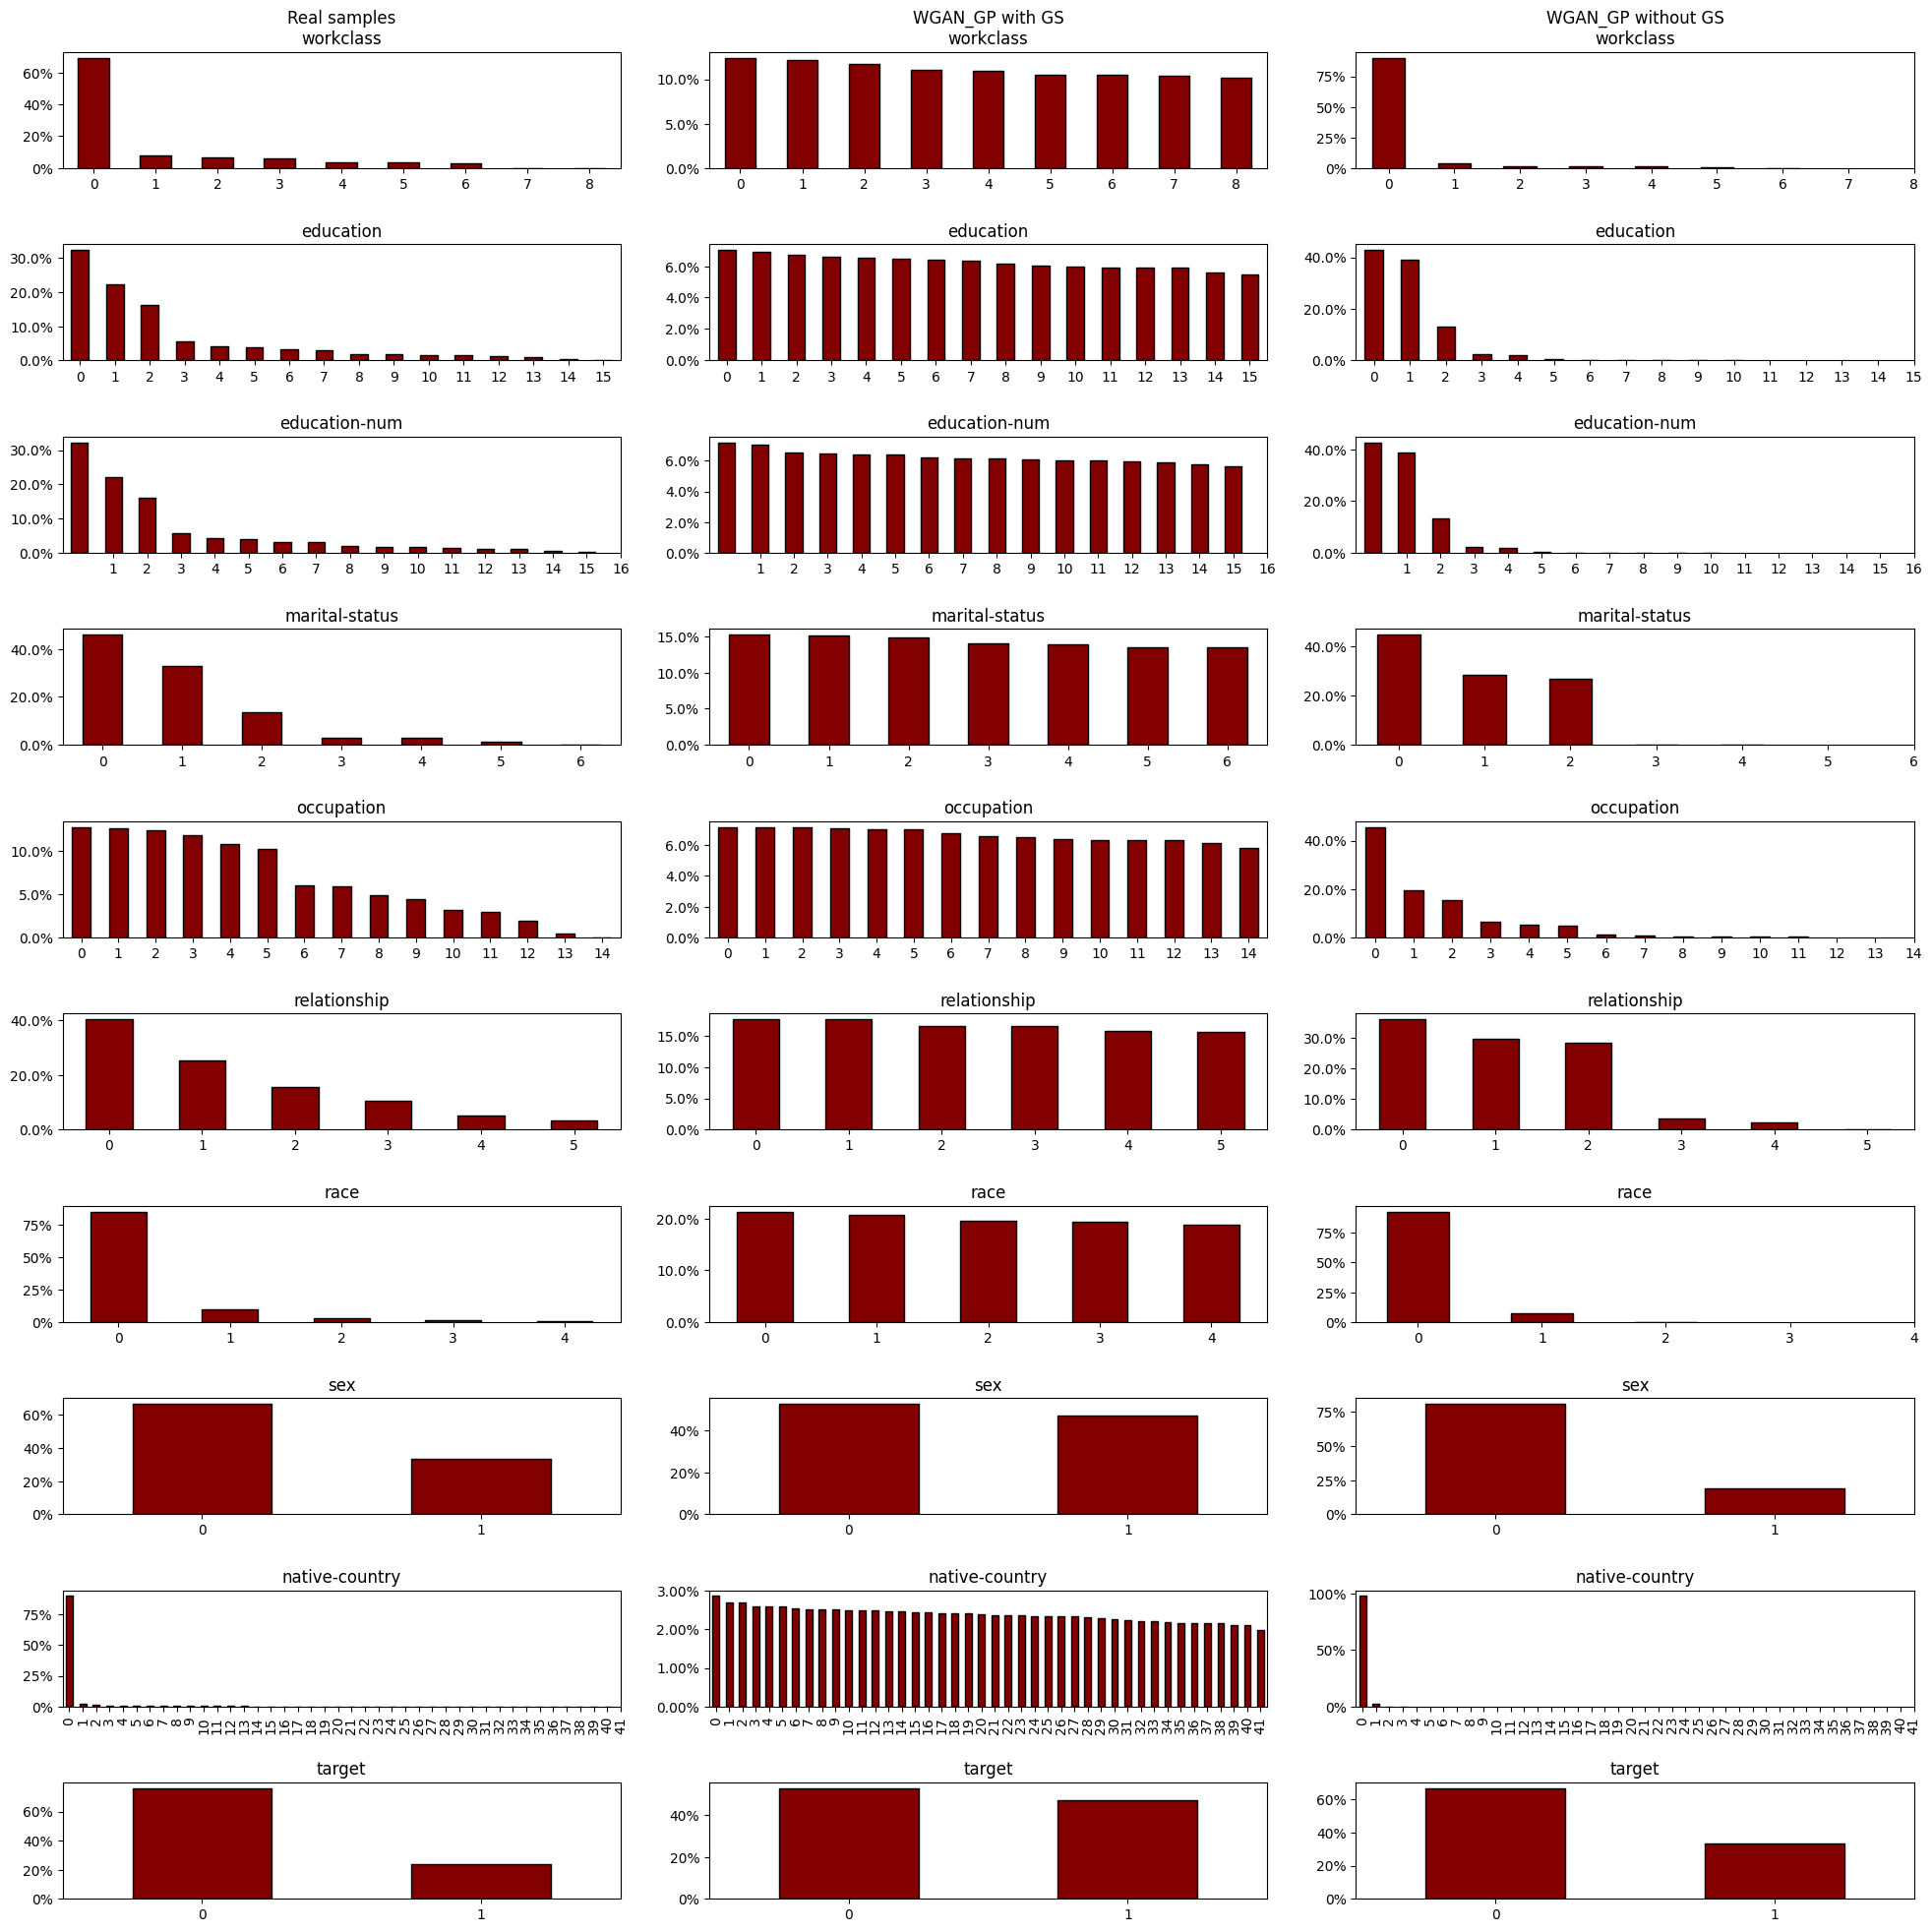

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from ydata_synthetic.utils.misc.colormaps import ydata_colormap

ydata_colors = ydata_colormap(1)

fig, axes = plt.subplots(nrows=len(cat_cols), ncols=3, figsize= (20,20))
for i, feat in enumerate(cat_cols):
    xticks=sorted(list(data[feat].unique()))
    for j, (name, samples) in enumerate({'Real samples': real_samples, 'WGAN_GP with GS': gs_samples, 'WGAN_GP without GS': no_gs_samples}.items()):
        (samples[feat].value_counts()/(0.01*sample_size)).plot(kind='bar', ax=axes[i, j], title=(name +'\n' if i==0 else '') + feat, colormap=ydata_colors, edgecolor='black',
        xticks=xticks, rot = 0 if len(xticks)<20 else None)
        axes[i, j].yaxis.set_major_formatter(PercentFormatter())
fig.tight_layout(pad=2.0)
plt.show()

Did you notice that the WGAN_GP without Gumbel-Softmax has a behaviour close to winner takes all in most of the features?
On the other hand the Gumbel Softmax lies in the balance between an uniform distribution and the winner takes all behaviour.
This is an expected trade-off that can be calibrated with the temperature argument of the Gumbel-Softmax (tau). You can learn more about this behaviour in the foundational articles shared in the introductory part.

With this final demonstration we are concluding the notebook, did enjoy learning about Gumbel-Softmax?
By default this feature is implemented in all the regular generators.

Feel free to adapt this notebook to play with different parameters, datasets or even other GANs of the repository.

Also, enjoy the improved categorical generation!